In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from operator import itemgetter 

**Load CONLL2003 data:**

In [2]:
conll_data_path = '/Users/michelle.morales@ibm.com/Desktop/NER-datasets-master/CONLL2003/'

In [3]:
dir_files = [f for f in listdir(conll_data_path) if isfile(join(conll_data_path, f))]

In [4]:
text_files = [f for f in dir_files if f.endswith('.txt')]

In [5]:
text_dict = {}
for f in text_files:
    with open(join(conll_data_path, f), 'rb') as read_f:
        text = read_f.read().decode("utf-8") # decode bytes to string, to work with pandas
        text_dict[f] = text

**Preprocess data:**

In [6]:
# Create one dataframe with all data
df = pd.DataFrame(columns=['text_type', 'sentence'])
for key in text_dict.keys():
    sentences = pd.Series(text_dict[key].split(sep='O\n\n'))
    if df.shape == (0,2):
        df['sentence'] = sentences
        df['text_type'] = [key.replace('.txt','')] * len(sentences)
    else:
        df_add = pd.DataFrame()
        df_add['sentence'] = sentences
        df_add['text_type'] = [key.replace('.txt','')] * len(sentences)
        df = df.append(df_add, ignore_index = True)

In [7]:
df['text_type'].value_counts()

train    14269
test      3501
valid     3320
Name: text_type, dtype: int64

In [8]:
# Data clean up
df = df[~df.sentence.str.contains("DOCSTART")] # Remove DOCSTARTs
df['sentence_list'] = df['sentence'].str.split('\n') # Convert each sentence string into a list of chunks

In [9]:
def get_info(sentence):
    words = []
    labels = []
    for s in sentence:
        if s != '':
            items = s.split()
            word = items[0]
            label = items[-1]
            words.append(word)
            labels.append(label)
    return words, labels

In [10]:
df[['words', 'labels']] = pd.DataFrame(df['sentence_list'].apply(lambda x: get_info(x)).tolist(), index=df.index) 

**Analyze and visualize data:**

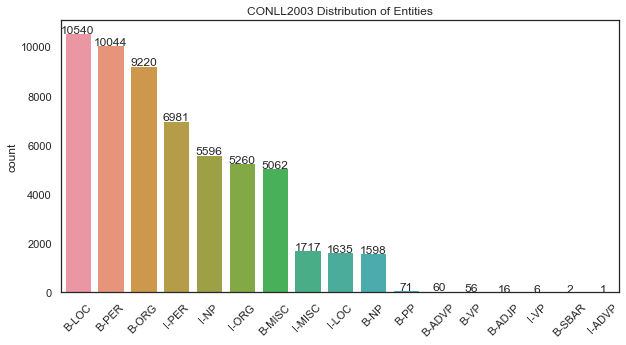

In [11]:
# Plot frequency of each entity type
all_labels = pd.Series(list(itertools.chain.from_iterable(df.labels.tolist()))) # Get entity labels
only_entities = all_labels[all_labels != 'O'] # Ignore O label

plt.figure(figsize=(10,5))
sns.set(style="white")
sns.set_palette("colorblind")
ax_entity = sns.countplot(only_entities, order = only_entities.value_counts().index)
for p in ax_entity.patches:
    height = p.get_height()
    ax_entity.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.0f}'.format(height),
            ha="center") 
    
ax_entity = ax_entity.set_xticklabels(ax_entity.get_xticklabels(), rotation=45)
plt = plt.title('CONLL2003 Distribution of Entities')

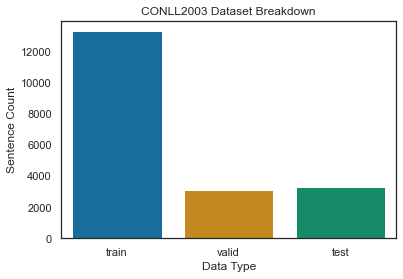

In [12]:
# Understand how much data we have for training/validating/testing a machine learning model
sns.set(style="white")
sns.set_palette("colorblind")
ax_data = sns.countplot(x="text_type", data=df)
ax_data = ax_data.set(xlabel='Data Type', ylabel='Sentence Count', title="CONLL2003 Dataset Breakdown")

**Model Training and Evaluation**

In [13]:
train = df[df['text_type'] == 'train']

In [22]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

In [24]:
import sparknlp
spark = sparknlp.start()
print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Exception: Java gateway process exited before sending its port number